##Setup

In [ ]:
import os
import time
import csv
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
from collections import Counter

seed = 42
torch.manual_seed(seed)

# cpu para verificação e cuda para treinamento
DEVICE = "cpu"
# DEVICE = "cuda" if torch.cuda.is_available else "cpu"

# Mount do path com os arquivos relevantes (dataset: https://www.kaggle.com/datasets/734b7bcb7ef13a045cbdd007a3c19874c2586ed0b02b4afc86126e89d00af8d2)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
general_path='/content/drive/MyDrive/'

Mounted at /content/drive


##Materiais estudados:

* You Only Look Once: Unified, Real-Time Object Detection (https://doi.org/10.48550/arXiv.1506.02640)
* Object Detection Metrics (https://github.com/rafaelpadilla/Object-Detection-Metrics)
* YOLOv1 from Scratch (https://youtu.be/n9_XyCGr-MI)

##1. O modelo YOLO: métricas e funcionamento

O problema da detecção de objetos consiste na identificação das classes de objetos relevantes e suas respectivas posições em dadas imagens. O modelo *You Only Look Once* (*YOLO*) atua em problemas desse tipo por meio da seguinte abordagem: os pixels da imagem dada são a entrada pela qual *bounding boxes* ("caixas" delimitantes que indicam a posição de objetos) e probabilidades de classes são geradas através uma única CNN.


###1.1. Métricas
Definições relevantes antes da abordagem das métricas de avaliação de modelos para o problema descrito devem ser feitas, entre elas: a chamada *Intersection Over Union* (*IOU*). Essa é uma medida baseada no Índice Jaccard que avalia a interseção entre duas bounding boxes, como a seguir:
\begin{align*}
IOU=\frac{\text{area}(B_p\cap B_{gt})}{\text{area}(B_p\cup B_{gt})},
\end{align*}
sendo que $B_p$ é a bounding box predita e $B_{gt}$ é a bounding box de ground truth. A medida IOU nos permite saber se as detecções são válidas (verdadeiro positivo) ou não (falso positivo). No verdadeiro positivo ($TP$), a detecção é correta e $IOU\geq \text{threshold}$, em que threshold é um valor de limiar para as avaliações, normalmente definida como $0.5$, $0.75$ ou $0.95$. No falso positivo ($FP$), a detecção é incorreta e $IOU<\text{threshold}$. No falso negativo ($FN$), a ground truth não é detectada. Além disso, o verdadeiro negativo não se aplica pois significa que a bounding box corretamente não é detectada pelo modelo, e muitas bounding boxes assim podem existir.

A precisão é a capacidade de um modelo de identificar apenas objetos relevantes, definida como
\begin{align*}
\text{Precisão}&=\frac{TP}{TP+FP}\\
&=\frac{TP}{\text{todas as detecções}}.
\end{align*}
O recall é a capacidade de um modelo de encontrar todas as bounding boxes de ground truth, definida como
\begin{align*}
\text{Recall}&=\frac{TP}{TP+FN}\\
&=\frac{TP}{\text{todas as ground truths}}.
\end{align*}

Abordemos a primeira métrica: a *curva Precisão$\times$Recall*. Essa métrica funciona por meio de uma curva para cada classe de objeto, relacionando a performance de um detector de objeto. Um detector de objeto é dito bom se a precisão continua alta conforme o recall aumenta, o que implica na consistência de precisão e recall altos caso o threshold varie. Um detector de objetos ruim precisa aumentar o número de objetos detectados (menor precisão) para que seja possível obter todos os objetos de ground truth (recall alto). Por esse motivo, a curva (precisão de ordenada e recall de abscissa) comumente começa com altos valores de precisão e vai diminuindo conforme o recall aumenta.

A segunda métrica é a chamada *Average Precision* (*AP*), mais utilizada para comparar modelos. Ela é definida como a área abaixo da curva de Precisão$\times$Recall e encontra-se no intervalo $[0,1]$. Para várias classes, é usada a *mean Average Precision* (*mAP*), que é a média das APs de todas as classes.


###1.2. Funcionamento
O sistema inicialmente divide a imagem em uma grade $S\times S$. As células da grade que contêm centros de objetos são responsáveis pela detecção dos objetos correspondentes. Cada célula prediz $B$ bounding boxes e suas pontuações de confiança. Confiança é definida como $Pr(Objeto)\times IOU_{pred}^{truth}$. Cada bounding box contém 5 predições: $x$, $y$, $w$, $h$ e a confiança. A coordenada $(x, y)$ corresponde ao centro da box em relação ao bounds da célula da grade. Os valores $w$ e $h$ são a largura e altura da box, respectivamente. Cada célula prediz $C$ classes condicionais de probabilidade $Pr(Classe_i|Objeto)$, condicionadas na célula contendo um objeto. O modelo prediz somente um conjunto de probabilidades de classe por célula, independentemente do valor $B$. As pontuações de confiança de cada classe para as boxes são dadas por
\begin{align*}
Pr(Classe_i|Objeto)\times Pr(Objeto)\times IOU_{pred}^{truth}=Pr(Classe_i)\times IOU_{pred}^{truth}.
\end{align*}
As predições são armazenadas como um tensor $S\times S\times (5B+C)$ (para cada célula na grade $S\times S$, prediz $B$ bounding boxes com seus 5 valores descritos anteriormente e $C$ probabilidades de classe).

A arquitetura do modelo consiste em 24 camadas convolucionais (com camadas de pooling intercaladas entre sequências específicas das camadas de convolução) seguidas por 2 camadas totalmente conectadas. A camada final prediz probabilidades de classe e coordenadas de bounding boxes.

Os valores $w$ e $h$ das bounding boxes são normalizados pela largura e altura da imagem em um intervalo $[0,1]$. Os valores $x$ e $y$ também ficam no mesmo intervalo pois são parametrizadas como offsets de células específicas. A função de ativação utilizada na última camada é a ReLU e a função utilizada nas outras camadas é a leaky ReLU, definida nesse caso como $x$ se $x>0$ e $0.1x$ caso contrário, sendo $x$ a entrada. Durante o treinamento, é atribuído somente um preditor de bounding box como responsável por predizer um objeto, levando em conta a predição com a maior $IOU_{pred}^{truth}$ atual. Dessa maneira, cada preditor especializado fica melhor em predizer específicos tamanhos, proporções ou classes de objeto, o que melhora o recall.

A função de perda (baseada na função de erro quadrático) a ser otimizada é a que segue:
\begin{align*}
\lambda_{coord}\sum_{i=0}^{S^2}\sum_{j=0}^B 𝟙_{ij}^{obj}\biggl[(x_i-\hat{x}_i)^2+(y_i-\hat{y}_i)^2\biggr]+\lambda_{coord}\sum_{i=0}^{S^2}\sum_{j=0}^B 𝟙_{ij}^{obj}\biggl[\biggl(\sqrt{w_i}-\sqrt{\hat{w}_i}\biggr)^2+\biggl(\sqrt{h_i}-\sqrt{\hat{h}_i}\biggr)^2\biggr]+\sum_{i=0}^{S^2}\sum_{j=0}^B 𝟙_{ij}^{obj}(C_i-\hat{C}_i)^2+\lambda_{noobj}\sum_{i=0}^{S^2}\sum_{j=0}^B 𝟙_{ij}^{noobj}(C_i-\hat{C}_i)^2+\sum_{i=0}^{S^2}𝟙_{i}^{obj}\sum_{c\in \text{classes}}(p_i(c)-\hat{p}_i(c))^2,
\end{align*}
sendo que $\lambda_{coord}$ e $\lambda_{noobj}$ são constantes para ajuste de perda das predições de coordenadas de bounding boxes e perda das predições de confiança para boxes que não contêm objetos, respectivamente, $𝟙_i^{obj}$ é a variável indicadora para o caso de algum objeto estar na célula $i$ e $𝟙_{ij}^{obj}$ é a variável indicadora que denota que o $j$-ésimo preditor de bounding box na célula $i$ é responsável pela predição ($𝟙_{ij}^{noobj}$ é como a primeira variável indicadora descrita, mas para o caso de nenhum objeto estar na célula $i$, com o $j$-ésimo preditor de bounding box dela sendo responsável pela predição). Essa função de perda penaliza o erro de classificação somente se um objeto está presente na célula analisada e também penaliza o erro de coordenadas de bounding box caso o preditor seja responsável pela box de ground truth.

##2. Implementação

In [ ]:
# Os códigos dessa seção foram extraídos de https://github.com/aladdinpersson/Machine-Learning-Collection/tree/master/ML/Pytorch/object_detection/YOLO

class VOCDataset(torch.utils.data.Dataset):
    def __init__(
        self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None, skiprows=None
    ):
        self.annotations = pd.read_csv(csv_file, skiprows=skiprows)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transform:
            # image = self.transform(image)
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i,j represents the cell row and cell column
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:

            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)

            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object already found for specific cell i,j
            # Note: This means we restrict to ONE object
            # per cell!
            if label_matrix[i, j, 20] == 0:
                # Set that there exists an object
                label_matrix[i, j, 20] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 21:25] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [ ]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU)
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms


def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

class_id_to_name = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
                    'car', 'cat', 'chair', 'cow', 'dining table', 'dog', 'horse',
                    'motorbike', 'person', 'potted plant', 'sheep', 'sofa',
                    'train', 'TV/monitor']
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        obj_class = class_id_to_name[int(box[0])]
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.annotate(obj_class, (upper_left_x * width + box[2] * width / 2, upper_left_y * height + box[3] * height / 2),
                    color='w', weight='bold', fontsize=6, ha='center', va='center')
        ax.add_patch(rect)

    plt.show()

def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes



def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def save_checkpoint(state, filename=general_path + "my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [ ]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper and VOC dataset is 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

In [ ]:
"""
Implementation of Yolo (v1) architecture
with slight modification with added BatchNorm.
"""

"""
Information about architecture config:
Tuple is structured by (kernel_size, filters, stride, padding)
"M" is simply maxpooling with stride 2x2 and kernel 2x2
List is structured by tuples and lastly int with number of repeats
"""

architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))


class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

In [ ]:
# Hyperparameters etc.
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 140
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = general_path + "my_checkpoint"
IMG_DIR = general_path + "images"
LABEL_DIR = general_path + "labels"


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    return sum(mean_loss)/len(mean_loss)


def train_main(LEARNING_RATE=2e-5):
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = VOCDataset(
        general_path + "100examples.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )

    for epoch in range(EPOCHS):
        #for x, y in train_loader:
        #   x = x.to(DEVICE)
        #   for idx in range(8):
        #       bboxes = cellboxes_to_boxes(model(x))
        #       bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        #       plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

        #    import sys
        #    sys.exit()

        print(f"\nEpoch: {epoch}")

        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4, box_format="midpoint", device=DEVICE
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")
        mean_avg_precs[-1].append(mean_avg_prec)

        mean_loss = train_fn(train_loader, model, optimizer, loss_fn)
        print(f"Mean loss was {mean_loss}")
        mean_losses[-1].append(mean_loss)

    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    lr_formatting = f"{LEARNING_RATE:.5f}"
    lr_formatting = lr_formatting[2:]
    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE + f"{lr_formatting}.pth.tar")
    #time.sleep(1)

LEARNING_RATES = [5e-4, 1e-4, 7e-5]
mean_avg_precs = []
mean_losses = []
dt = []
for LEARNING_RATE in LEARNING_RATES:
    mean_avg_precs.append([])
    mean_losses.append([])
    print(f"\nLearning rate: {LEARNING_RATE}")
    t0 = time.time()
    train_main(LEARNING_RATE)
    t1 = time.time()
    dt.append(t1 - t0)


Learning rate: 0.0005

Epoch: 0
Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.44it/s, loss=996]

Mean loss was 3026.3548583984375

Epoch: 1


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.53it/s, loss=741]

Mean loss was 1022.3925170898438

Epoch: 2


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.23it/s, loss=547]

Mean loss was 655.3919372558594

Epoch: 3


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.46it/s, loss=211]

Mean loss was 433.72862243652344

Epoch: 4


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=359]

Mean loss was 337.168207804362

Epoch: 5


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=308]

Mean loss was 274.09344482421875

Epoch: 6


Train mAP: 0.0016865074867382646


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=160]

Mean loss was 234.58910369873047

Epoch: 7


Train mAP: 3.0525028705596924e-05


100%|██████████| 6/6 [00:02<00:00,  2.44it/s, loss=271]

Mean loss was 228.5120417277018

Epoch: 8


Train mAP: 0.00024100777227431536


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=162]

Mean loss was 189.61516316731772

Epoch: 9


Train mAP: 0.0008899938547983766


100%|██████████| 6/6 [00:02<00:00,  2.50it/s, loss=216]

Mean loss was 184.03980255126953

Epoch: 10


Train mAP: 0.00015296766650862992


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=226]

Mean loss was 175.2869440714518

Epoch: 11


Train mAP: 0.0020410935394465923


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=211]

Mean loss was 213.66221618652344

Epoch: 12


Train mAP: 0.0007509712013415992


100%|██████████| 6/6 [00:02<00:00,  2.44it/s, loss=180]

Mean loss was 179.21872202555338

Epoch: 13


Train mAP: 0.0009428330813534558


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=193]

Mean loss was 166.9535140991211

Epoch: 14


Train mAP: 0.001266558887436986


100%|██████████| 6/6 [00:02<00:00,  2.07it/s, loss=185]

Mean loss was 165.19155629475912

Epoch: 15


Train mAP: 0.014991847798228264


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=236]

Mean loss was 176.97654469807944

Epoch: 16


Train mAP: 0.0002174589753849432


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=158]

Mean loss was 170.22940572102866

Epoch: 17


Train mAP: 0.006657248828560114


100%|██████████| 6/6 [00:02<00:00,  2.02it/s, loss=193]

Mean loss was 168.9269027709961

Epoch: 18


Train mAP: 0.0034803305752575397


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=208]

Mean loss was 162.6667048136393

Epoch: 19


Train mAP: 0.0016077372711151838


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=93]

Mean loss was 218.9838612874349

Epoch: 20


Train mAP: 0.001573947025462985


100%|██████████| 6/6 [00:03<00:00,  1.97it/s, loss=225]

Mean loss was 183.70948028564453

Epoch: 21


Train mAP: 0.0011058172676712275


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=180]

Mean loss was 205.1941655476888

Epoch: 22


Train mAP: 0.002830484416335821


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=208]

Mean loss was 170.71035130818686

Epoch: 23


Train mAP: 0.0008456882205791771


100%|██████████| 6/6 [00:03<00:00,  1.93it/s, loss=231]

Mean loss was 190.30713399251303

Epoch: 24


Train mAP: 0.005585141945630312


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=259]

Mean loss was 180.57355372111002

Epoch: 25


Train mAP: 0.0006710417801514268


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=180]

Mean loss was 219.08018747965494

Epoch: 26


Train mAP: 0.0031322743743658066


100%|██████████| 6/6 [00:05<00:00,  1.00it/s, loss=206]

Mean loss was 152.36314010620117

Epoch: 27


Train mAP: 0.0159827321767807


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=184]

Mean loss was 213.05859756469727

Epoch: 28


Train mAP: 0.004448977764695883


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=193]

Mean loss was 170.31446965535483

Epoch: 29


Train mAP: 0.002110730390995741


100%|██████████| 6/6 [00:03<00:00,  1.96it/s, loss=119]

Mean loss was 185.77119827270508

Epoch: 30


Train mAP: 0.002589050680398941


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=220]

Mean loss was 178.25928497314453

Epoch: 31


Train mAP: 0.0016197111690416932


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=142]

Mean loss was 181.26858266194662

Epoch: 32


Train mAP: 0.007181429769843817


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=211]

Mean loss was 176.95935185750326

Epoch: 33


Train mAP: 0.011163648217916489


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=123]

Mean loss was 139.80521774291992

Epoch: 34


Train mAP: 0.012478353455662727


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=145]

Mean loss was 152.97050984700522

Epoch: 35


Train mAP: 0.02174239419400692


100%|██████████| 6/6 [00:02<00:00,  2.23it/s, loss=180]

Mean loss was 149.2991854349772

Epoch: 36


Train mAP: 0.04957804083824158


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=142]

Mean loss was 147.04358418782553

Epoch: 37


Train mAP: 0.0264064259827137


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=147]

Mean loss was 164.68550745646158

Epoch: 38


Train mAP: 0.07108400762081146


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=132]

Mean loss was 131.55208460489908

Epoch: 39


Train mAP: 0.04376782104372978


100%|██████████| 6/6 [00:02<00:00,  2.21it/s, loss=172]


Mean loss was 139.84142303466797

Epoch: 40
Train mAP: 0.03005385398864746


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=161]

Mean loss was 140.1787249247233

Epoch: 41


Train mAP: 0.053384698927402496


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=156]

Mean loss was 131.90310541788736

Epoch: 42


Train mAP: 0.055540841072797775


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=135]

Mean loss was 130.53243764241537

Epoch: 43


Train mAP: 0.10812652111053467


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=142]

Mean loss was 135.62516276041666

Epoch: 44


Train mAP: 0.12245042622089386


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=117]

Mean loss was 127.33665593465169

Epoch: 45


Train mAP: 0.0758604109287262


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=105]

Mean loss was 128.75113423665366

Epoch: 46


Train mAP: 0.09797223657369614


100%|██████████| 6/6 [00:02<00:00,  2.23it/s, loss=142]

Mean loss was 123.65243021647136

Epoch: 47


Train mAP: 0.04970603436231613


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=237]

Mean loss was 132.0728848775228

Epoch: 48


Train mAP: 0.09921755641698837


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=145]

Mean loss was 129.05157216389975

Epoch: 49


Train mAP: 0.017125029116868973


100%|██████████| 6/6 [00:03<00:00,  1.51it/s, loss=119]

Mean loss was 128.05537923177084

Epoch: 50


Train mAP: 0.02120765671133995


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=189]

Mean loss was 147.3977508544922

Epoch: 51


Train mAP: 0.08095705509185791


100%|██████████| 6/6 [00:03<00:00,  1.66it/s, loss=219]

Mean loss was 144.99947611490884

Epoch: 52


Train mAP: 0.04881543293595314


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=156]

Mean loss was 133.0352414449056

Epoch: 53


Train mAP: 0.03735852986574173


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=89.6]

Mean loss was 123.03444035847981

Epoch: 54


Train mAP: 0.06366059184074402


100%|██████████| 6/6 [00:03<00:00,  1.57it/s, loss=147]

Mean loss was 122.16837692260742

Epoch: 55


Train mAP: 0.07151252776384354


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=98.9]

Mean loss was 114.94852828979492

Epoch: 56


Train mAP: 0.10982654988765717


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=74]

Mean loss was 114.32838439941406

Epoch: 57


Train mAP: 0.07608282566070557


100%|██████████| 6/6 [00:02<00:00,  2.13it/s, loss=142]

Mean loss was 121.75439071655273

Epoch: 58


Train mAP: 0.07235230505466461


100%|██████████| 6/6 [00:02<00:00,  2.08it/s, loss=99.6]

Mean loss was 109.20840072631836

Epoch: 59


Train mAP: 0.08856970071792603


100%|██████████| 6/6 [00:02<00:00,  2.05it/s, loss=173]

Mean loss was 114.53059260050456

Epoch: 60


Train mAP: 0.06662903726100922


100%|██████████| 6/6 [00:03<00:00,  1.75it/s, loss=123]

Mean loss was 108.6127815246582

Epoch: 61


Train mAP: 0.06261274218559265


100%|██████████| 6/6 [00:02<00:00,  2.17it/s, loss=132]

Mean loss was 111.1769167582194

Epoch: 62


Train mAP: 0.09972977638244629


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=99.2]

Mean loss was 104.07839075724284

Epoch: 63


Train mAP: 0.0880429744720459


100%|██████████| 6/6 [00:02<00:00,  2.03it/s, loss=98.4]

Mean loss was 100.37862141927083

Epoch: 64


Train mAP: 0.06214488670229912


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=91.3]

Mean loss was 89.11793963114421

Epoch: 65


Train mAP: 0.1071198359131813


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=120]

Mean loss was 102.73150126139323

Epoch: 66


Train mAP: 0.15996606647968292


100%|██████████| 6/6 [00:02<00:00,  2.01it/s, loss=108]

Mean loss was 99.9615592956543

Epoch: 67


Train mAP: 0.08790931850671768


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=137]

Mean loss was 99.93742116292317

Epoch: 68


Train mAP: 0.12562282383441925


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=94]

Mean loss was 98.06645965576172

Epoch: 69


Train mAP: 0.16273190081119537


100%|██████████| 6/6 [00:03<00:00,  1.93it/s, loss=74.9]

Mean loss was 91.63676834106445

Epoch: 70


Train mAP: 0.23357900977134705


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=143]

Mean loss was 110.47468948364258

Epoch: 71


Train mAP: 0.020728573203086853


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=122]

Mean loss was 141.79987462361655

Epoch: 72


Train mAP: 0.034931473433971405


100%|██████████| 6/6 [00:03<00:00,  1.87it/s, loss=104]

Mean loss was 125.26688385009766

Epoch: 73


Train mAP: 0.02828654646873474


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=140]

Mean loss was 107.11367289225261

Epoch: 74


Train mAP: 0.10842634737491608


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=109]

Mean loss was 115.3959566752116

Epoch: 75


Train mAP: 0.06423541158437729


100%|██████████| 6/6 [00:03<00:00,  1.89it/s, loss=105]

Mean loss was 107.942626953125

Epoch: 76


Train mAP: 0.09320804476737976


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=85.8]

Mean loss was 92.68622080485027

Epoch: 77


Train mAP: 0.15389525890350342


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=92.2]

Mean loss was 94.23921076456706

Epoch: 78


Train mAP: 0.11149869859218597


100%|██████████| 6/6 [00:03<00:00,  1.88it/s, loss=77.2]

Mean loss was 84.18369166056316

Epoch: 79


Train mAP: 0.09391891211271286


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=106]

Mean loss was 85.8201421101888

Epoch: 80


Train mAP: 0.13279888033866882


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=87.4]

Mean loss was 84.4954833984375

Epoch: 81


Train mAP: 0.18572643399238586


100%|██████████| 6/6 [00:04<00:00,  1.48it/s, loss=81.2]

Mean loss was 83.78903325398763

Epoch: 82


Train mAP: 0.17439553141593933


100%|██████████| 6/6 [00:03<00:00,  1.98it/s, loss=156]

Mean loss was 92.3195743560791

Epoch: 83


Train mAP: 0.22168560326099396


100%|██████████| 6/6 [00:03<00:00,  1.88it/s, loss=82]

Mean loss was 86.82984161376953

Epoch: 84


Train mAP: 0.25108879804611206


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=47.6]

Mean loss was 85.61782773335774

Epoch: 85


Train mAP: 0.21400320529937744


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=83.8]

Mean loss was 80.69422149658203

Epoch: 86


Train mAP: 0.12757055461406708


100%|██████████| 6/6 [00:03<00:00,  1.98it/s, loss=84.9]

Mean loss was 76.59526252746582

Epoch: 87


Train mAP: 0.15981805324554443


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=112]

Mean loss was 81.84965515136719

Epoch: 88


Train mAP: 0.19821149110794067


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=105]

Mean loss was 75.69845453898112

Epoch: 89


Train mAP: 0.23603880405426025


100%|██████████| 6/6 [00:02<00:00,  2.16it/s, loss=99]

Mean loss was 78.52075640360515

Epoch: 90


Train mAP: 0.28821200132369995


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=74.4]

Mean loss was 73.08976236979167

Epoch: 91


Train mAP: 0.2457413673400879


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=114]

Mean loss was 86.84169069925944

Epoch: 92


Train mAP: 0.22301845252513885


100%|██████████| 6/6 [00:02<00:00,  2.19it/s, loss=69.7]

Mean loss was 81.08716583251953

Epoch: 93


Train mAP: 0.22349517047405243


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=59.8]

Mean loss was 74.88120333353679

Epoch: 94


Train mAP: 0.30898886919021606


100%|██████████| 6/6 [00:02<00:00,  2.23it/s, loss=74.3]

Mean loss was 74.3125826517741

Epoch: 95


Train mAP: 0.23706182837486267


100%|██████████| 6/6 [00:02<00:00,  2.13it/s, loss=84.2]

Mean loss was 79.6514892578125

Epoch: 96


Train mAP: 0.26533374190330505


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=68.3]

Mean loss was 72.09224192301433

Epoch: 97


Train mAP: 0.279235303401947


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=63.1]

Mean loss was 72.72614034016927

Epoch: 98


Train mAP: 0.3950878977775574


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=83.6]

Mean loss was 73.34038798014323

Epoch: 99


Train mAP: 0.28640681505203247


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=80]

Mean loss was 66.51829401652019

Epoch: 100


Train mAP: 0.30764976143836975


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=58.2]

Mean loss was 68.5630734761556

Epoch: 101


Train mAP: 0.2925686836242676


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=82.6]

Mean loss was 67.09834225972493

Epoch: 102


Train mAP: 0.24450889229774475


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=70.8]

Mean loss was 65.26062838236491

Epoch: 103


Train mAP: 0.3342883586883545


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=73.3]

Mean loss was 61.218993504842125

Epoch: 104


Train mAP: 0.39796996116638184


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=54.7]

Mean loss was 60.848869959513344

Epoch: 105


Train mAP: 0.44101500511169434


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=70.1]

Mean loss was 60.86922963460287

Epoch: 106


Train mAP: 0.39198869466781616


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=65.9]

Mean loss was 55.24059168497721

Epoch: 107


Train mAP: 0.43088334798812866


100%|██████████| 6/6 [00:02<00:00,  2.15it/s, loss=72.9]

Mean loss was 59.9266300201416

Epoch: 108


Train mAP: 0.300325870513916


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=35.5]

Mean loss was 52.26807975769043

Epoch: 109


Train mAP: 0.3922046422958374


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=41.5]

Mean loss was 66.78263982137044

Epoch: 110


Train mAP: 0.39828795194625854


100%|██████████| 6/6 [00:02<00:00,  2.05it/s, loss=40.6]

Mean loss was 58.2176939646403

Epoch: 111


Train mAP: 0.4093734323978424


100%|██████████| 6/6 [00:02<00:00,  2.07it/s, loss=61.7]

Mean loss was 59.302328745524086

Epoch: 112


Train mAP: 0.47066792845726013


100%|██████████| 6/6 [00:03<00:00,  1.84it/s, loss=53]

Mean loss was 54.709031422932945

Epoch: 113


Train mAP: 0.5064867734909058


100%|██████████| 6/6 [00:02<00:00,  2.01it/s, loss=53.9]

Mean loss was 57.61896069844564

Epoch: 114


Train mAP: 0.41369348764419556


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=48.3]

Mean loss was 53.60586738586426

Epoch: 115


Train mAP: 0.349321186542511


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=61.5]

Mean loss was 59.646602630615234

Epoch: 116


Train mAP: 0.4420185089111328


100%|██████████| 6/6 [00:02<00:00,  2.07it/s, loss=55.4]

Mean loss was 65.0875358581543

Epoch: 117


Train mAP: 0.46206530928611755


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=48.7]

Mean loss was 68.92899576822917

Epoch: 118


Train mAP: 0.3525363802909851


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=83.7]

Mean loss was 79.1439921061198

Epoch: 119


Train mAP: 0.47160014510154724


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=61.1]

Mean loss was 58.11159324645996

Epoch: 120


Train mAP: 0.3747721314430237


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=62.4]

Mean loss was 57.5729071299235

Epoch: 121


Train mAP: 0.5030399560928345


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=56.8]

Mean loss was 52.02330716451009

Epoch: 122


Train mAP: 0.46766528487205505


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=50.7]

Mean loss was 57.83171081542969

Epoch: 123


Train mAP: 0.5485469102859497


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=74.2]

Mean loss was 58.62892468770345

Epoch: 124


Train mAP: 0.5024749636650085


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=49]

Mean loss was 56.0104726155599

Epoch: 125


Train mAP: 0.5229347944259644


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=64.1]

Mean loss was 61.45852851867676

Epoch: 126


Train mAP: 0.4010012149810791


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=45]

Mean loss was 58.212175369262695

Epoch: 127


Train mAP: 0.5696545839309692


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=59.8]

Mean loss was 56.81329536437988

Epoch: 128


Train mAP: 0.46202635765075684


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=35.7]

Mean loss was 56.23789850870768

Epoch: 129


Train mAP: 0.6225089430809021


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=54.5]

Mean loss was 50.95654296875

Epoch: 130


Train mAP: 0.617774248123169


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=68.9]

Mean loss was 53.54524294535319

Epoch: 131


Train mAP: 0.5860255360603333


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=66]

Mean loss was 47.595401763916016

Epoch: 132


Train mAP: 0.6865943670272827


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=47.7]

Mean loss was 43.8666566212972

Epoch: 133


Train mAP: 0.5611785650253296


100%|██████████| 6/6 [00:03<00:00,  1.78it/s, loss=46.4]

Mean loss was 50.150594075520836

Epoch: 134


Train mAP: 0.5736275911331177


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=61.5]

Mean loss was 50.46230824788412

Epoch: 135


Train mAP: 0.5358783602714539


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=58.8]

Mean loss was 49.59092013041178

Epoch: 136


Train mAP: 0.6749894618988037


100%|██████████| 6/6 [00:03<00:00,  1.90it/s, loss=61.4]

Mean loss was 52.31137148539225

Epoch: 137


Train mAP: 0.6263067126274109


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=64.2]

Mean loss was 62.58388455708822

Epoch: 138


Train mAP: 0.43979114294052124


100%|██████████| 6/6 [00:02<00:00,  2.24it/s, loss=52.5]

Mean loss was 67.1288350423177

Epoch: 139


Train mAP: 0.3776046335697174


100%|██████████| 6/6 [00:03<00:00,  1.77it/s, loss=81.2]


Mean loss was 70.5730152130127
=> Saving checkpoint

Learning rate: 0.0001

Epoch: 0
Train mAP: 0.0


100%|██████████| 6/6 [00:03<00:00,  1.86it/s, loss=1.11e+3]

Mean loss was 1136.1581115722656

Epoch: 1


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=441]

Mean loss was 612.1063435872396

Epoch: 2


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.11it/s, loss=357]

Mean loss was 469.3256022135417

Epoch: 3


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.01it/s, loss=336]

Mean loss was 343.1661071777344

Epoch: 4


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=389]

Mean loss was 300.8599344889323

Epoch: 5


Train mAP: 0.0008609207579866052


100%|██████████| 6/6 [00:04<00:00,  1.46it/s, loss=166]

Mean loss was 227.708984375

Epoch: 6


Train mAP: 0.0007678101537749171


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=204]

Mean loss was 190.50831349690756

Epoch: 7


Train mAP: 0.0011218695435672998


100%|██████████| 6/6 [00:02<00:00,  2.04it/s, loss=153]

Mean loss was 163.3150863647461

Epoch: 8


Train mAP: 0.003003730671480298


100%|██████████| 6/6 [00:03<00:00,  1.63it/s, loss=130]

Mean loss was 158.63032658894858

Epoch: 9


Train mAP: 0.013756071217358112


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=202]

Mean loss was 128.86511357625326

Epoch: 10


Train mAP: 0.011265275999903679


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=112]

Mean loss was 114.94379170735677

Epoch: 11


Train mAP: 0.06752756983041763


100%|██████████| 6/6 [00:03<00:00,  1.65it/s, loss=103]

Mean loss was 102.44898351033528

Epoch: 12


Train mAP: 0.2708515524864197


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=83.6]

Mean loss was 89.08371225992839

Epoch: 13


Train mAP: 0.3891056180000305


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=77.2]

Mean loss was 86.76246007283528

Epoch: 14


Train mAP: 0.48442286252975464


100%|██████████| 6/6 [00:03<00:00,  1.67it/s, loss=82.1]

Mean loss was 83.73872057596843

Epoch: 15


Train mAP: 0.44293585419654846


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=69.7]

Mean loss was 78.08824412027995

Epoch: 16


Train mAP: 0.5045323967933655


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=109]

Mean loss was 72.03382619222005

Epoch: 17


Train mAP: 0.6369346976280212


100%|██████████| 6/6 [00:02<00:00,  2.21it/s, loss=63.1]

Mean loss was 67.46298599243164

Epoch: 18


Train mAP: 0.6409721970558167


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=80.2]

Mean loss was 65.4046745300293

Epoch: 19


Train mAP: 0.7505906820297241


100%|██████████| 6/6 [00:03<00:00,  1.86it/s, loss=86.8]

Mean loss was 61.11921819051107

Epoch: 20


Train mAP: 0.7809369564056396


100%|██████████| 6/6 [00:02<00:00,  2.23it/s, loss=66.4]

Mean loss was 62.107049306233726

Epoch: 21


Train mAP: 0.8210402727127075


100%|██████████| 6/6 [00:03<00:00,  1.69it/s, loss=64.3]

Mean loss was 63.31098747253418

Epoch: 22


Train mAP: 0.8476999402046204


100%|██████████| 6/6 [00:02<00:00,  2.17it/s, loss=93.6]

Mean loss was 63.20340474446615

Epoch: 23


Train mAP: 0.8406085968017578


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=64]

Mean loss was 56.90912055969238

Epoch: 24


Train mAP: 0.7457385659217834


100%|██████████| 6/6 [00:03<00:00,  1.56it/s, loss=68]

Mean loss was 56.38353157043457

Epoch: 25


Train mAP: 0.8120187520980835


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=75.1]

Mean loss was 66.51596132914226

Epoch: 26


Train mAP: 0.7742571830749512


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=57.1]

Mean loss was 62.40471903483073

Epoch: 27


Train mAP: 0.7430400848388672


100%|██████████| 6/6 [00:02<00:00,  2.20it/s, loss=59.2]

Mean loss was 57.99707221984863

Epoch: 28


Train mAP: 0.8434420824050903


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=68.7]

Mean loss was 53.17155202229818

Epoch: 29


Train mAP: 0.817160427570343


100%|██████████| 6/6 [00:03<00:00,  1.64it/s, loss=68.1]

Mean loss was 49.549856185913086

Epoch: 30


Train mAP: 0.8780595660209656


100%|██████████| 6/6 [00:02<00:00,  2.04it/s, loss=56.8]

Mean loss was 45.04040495554606

Epoch: 31


Train mAP: 0.8496434092521667


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=43]

Mean loss was 49.61374155680338

Epoch: 32


Train mAP: 0.7831559181213379


100%|██████████| 6/6 [00:02<00:00,  2.03it/s, loss=40.3]

Mean loss was 41.67636489868164

Epoch: 33


Train mAP: 0.8469794988632202


100%|██████████| 6/6 [00:02<00:00,  2.18it/s, loss=38.1]

Mean loss was 44.735286712646484

Epoch: 34


Train mAP: 0.7933133244514465


100%|██████████| 6/6 [00:02<00:00,  2.19it/s, loss=51.8]

Mean loss was 46.7839142481486

Epoch: 35


Train mAP: 0.8630039095878601


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=42.4]

Mean loss was 46.33835252126058

Epoch: 36


Train mAP: 0.7695328593254089


100%|██████████| 6/6 [00:03<00:00,  1.97it/s, loss=56.7]

Mean loss was 50.789868672688804

Epoch: 37


Train mAP: 0.8625718951225281


100%|██████████| 6/6 [00:03<00:00,  1.91it/s, loss=45.8]

Mean loss was 49.25703239440918

Epoch: 38


Train mAP: 0.907814621925354


100%|██████████| 6/6 [00:02<00:00,  2.19it/s, loss=54]

Mean loss was 51.58812395731608

Epoch: 39


Train mAP: 0.8001176714897156


100%|██████████| 6/6 [00:02<00:00,  2.08it/s, loss=37.9]

Mean loss was 50.33274459838867

Epoch: 40


Train mAP: 0.8666189312934875


100%|██████████| 6/6 [00:03<00:00,  1.72it/s, loss=43.4]

Mean loss was 48.6131165822347

Epoch: 41


Train mAP: 0.8692589998245239


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=44.4]

Mean loss was 47.213540395100914

Epoch: 42


Train mAP: 0.8608008623123169


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=34.1]

Mean loss was 47.74304676055908

Epoch: 43


Train mAP: 0.8339508771896362


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=47.8]

Mean loss was 47.59115219116211

Epoch: 44


Train mAP: 0.8782401084899902


100%|██████████| 6/6 [00:03<00:00,  1.91it/s, loss=62.4]

Mean loss was 43.79038047790527

Epoch: 45


Train mAP: 0.8893896341323853


100%|██████████| 6/6 [00:03<00:00,  1.65it/s, loss=72.3]

Mean loss was 45.732970555623375

Epoch: 46


Train mAP: 0.8841925859451294


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=48.3]

Mean loss was 39.64335060119629

Epoch: 47


Train mAP: 0.8370643854141235


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=33.3]

Mean loss was 42.0325231552124

Epoch: 48


Train mAP: 0.8861856460571289


100%|██████████| 6/6 [00:03<00:00,  1.75it/s, loss=37.2]

Mean loss was 43.83591270446777

Epoch: 49


Train mAP: 0.8882104158401489


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=37.5]

Mean loss was 41.28407287597656

Epoch: 50


Train mAP: 0.9102311134338379


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=45.7]

Mean loss was 38.26798629760742

Epoch: 51


Train mAP: 0.8637627363204956


100%|██████████| 6/6 [00:03<00:00,  1.88it/s, loss=34.8]

Mean loss was 38.76690673828125

Epoch: 52


Train mAP: 0.8203896284103394


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=37.8]

Mean loss was 32.713700930277504

Epoch: 53


Train mAP: 0.8977569341659546


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=40.4]

Mean loss was 35.88326199849447

Epoch: 54


Train mAP: 0.844249427318573


100%|██████████| 6/6 [00:03<00:00,  1.92it/s, loss=20.8]

Mean loss was 32.489919662475586

Epoch: 55


Train mAP: 0.9046965837478638


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=57]

Mean loss was 38.39243761698405

Epoch: 56


Train mAP: 0.908593475818634


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=30.4]

Mean loss was 28.048518816630047

Epoch: 57


Train mAP: 0.9147570729255676


100%|██████████| 6/6 [00:03<00:00,  1.85it/s, loss=33.3]

Mean loss was 33.181275367736816

Epoch: 58


Train mAP: 0.8768675923347473


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=19.8]

Mean loss was 30.052856127421062

Epoch: 59


Train mAP: 0.8921772837638855


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=35.5]

Mean loss was 30.739935557047527

Epoch: 60


Train mAP: 0.8601905703544617


100%|██████████| 6/6 [00:03<00:00,  1.75it/s, loss=22.8]

Mean loss was 30.984428723653156

Epoch: 61


Train mAP: 0.9520877599716187


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=26.3]

Mean loss was 39.235188802083336

Epoch: 62


Train mAP: 0.9816064834594727


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=25]

Mean loss was 29.4931427637736

Epoch: 63


Train mAP: 0.9144178628921509


100%|██████████| 6/6 [00:03<00:00,  1.89it/s, loss=26]

Mean loss was 26.484985033671062

Epoch: 64


Train mAP: 0.9149560928344727


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=24]

Mean loss was 25.060545603434246

Epoch: 65


Train mAP: 0.9399927258491516


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=27.8]

Mean loss was 24.644962310791016

Epoch: 66


Train mAP: 0.8575038909912109


100%|██████████| 6/6 [00:03<00:00,  1.67it/s, loss=20.8]

Mean loss was 26.202242533365887

Epoch: 67


Train mAP: 0.8944616317749023


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=21.8]

Mean loss was 22.19936466217041

Epoch: 68


Train mAP: 0.9741265177726746


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=31.4]

Mean loss was 24.090174674987793

Epoch: 69


Train mAP: 0.9849196672439575


100%|██████████| 6/6 [00:03<00:00,  1.84it/s, loss=27.6]

Mean loss was 21.605190912882488

Epoch: 70


Train mAP: 0.9475369453430176


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=25.3]

Mean loss was 23.981996377309162

Epoch: 71


Train mAP: 0.9216935038566589


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=25.1]

Mean loss was 27.95458730061849

Epoch: 72


Train mAP: 0.9656670689582825


100%|██████████| 6/6 [00:03<00:00,  1.88it/s, loss=23.1]

Mean loss was 26.141987959543865

Epoch: 73


Train mAP: 0.9602640867233276


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=32.6]

Mean loss was 24.44677956899007

Epoch: 74


Train mAP: 0.9374961853027344


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=23.7]

Mean loss was 32.97800668080648

Epoch: 75


Train mAP: 0.924811065196991


100%|██████████| 6/6 [00:03<00:00,  1.87it/s, loss=18.1]

Mean loss was 27.037190437316895

Epoch: 76


Train mAP: 0.8736529350280762


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=22]

Mean loss was 22.020958582560223

Epoch: 77


Train mAP: 0.925082802772522


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=23]

Mean loss was 22.957740147908527

Epoch: 78


Train mAP: 0.9016213417053223


100%|██████████| 6/6 [00:03<00:00,  1.91it/s, loss=17.9]

Mean loss was 20.818322499593098

Epoch: 79


Train mAP: 0.8771266937255859


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=22.4]

Mean loss was 25.12529532114665

Epoch: 80


Train mAP: 0.8701295852661133


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=31]

Mean loss was 24.131484667460125

Epoch: 81


Train mAP: 0.8530217409133911


100%|██████████| 6/6 [00:03<00:00,  1.89it/s, loss=25.9]

Mean loss was 18.868999163309734

Epoch: 82


Train mAP: 0.9377554059028625


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=18.8]

Mean loss was 19.720189094543457

Epoch: 83


Train mAP: 0.9337851405143738


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=13.5]

Mean loss was 17.59631109237671

Epoch: 84


Train mAP: 0.9415720105171204


100%|██████████| 6/6 [00:03<00:00,  1.81it/s, loss=15.5]

Mean loss was 14.684753259023031

Epoch: 85


Train mAP: 0.9329556226730347


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=14]

Mean loss was 14.343123118082682

Epoch: 86


Train mAP: 0.9616049528121948


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=13.3]

Mean loss was 15.410650889078775

Epoch: 87


Train mAP: 0.9164400100708008


100%|██████████| 6/6 [00:03<00:00,  1.80it/s, loss=14.7]

Mean loss was 14.48779567082723

Epoch: 88


Train mAP: 0.967178225517273


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=13.3]

Mean loss was 15.207586924235025

Epoch: 89


Train mAP: 0.9612950086593628


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=30.9]

Mean loss was 16.949416955312092

Epoch: 90


Train mAP: 0.9437891840934753


100%|██████████| 6/6 [00:03<00:00,  1.89it/s, loss=17.7]

Mean loss was 15.109692732493082

Epoch: 91


Train mAP: 0.8989769816398621


100%|██████████| 6/6 [00:02<00:00,  2.21it/s, loss=22.1]

Mean loss was 16.964517911275227

Epoch: 92


Train mAP: 0.9120577573776245


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=14.3]

Mean loss was 26.803258260091145

Epoch: 93


Train mAP: 0.9029200673103333


100%|██████████| 6/6 [00:02<00:00,  2.02it/s, loss=29.7]

Mean loss was 25.552531878153484

Epoch: 94


Train mAP: 0.9065834283828735


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=16.7]

Mean loss was 28.485604763031006

Epoch: 95


Train mAP: 0.913209080696106


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=44.3]

Mean loss was 27.290493965148926

Epoch: 96


Train mAP: 0.9089978337287903


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=47.2]

Mean loss was 24.350377877553303

Epoch: 97


Train mAP: 0.967232346534729


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=10.4]

Mean loss was 20.719029267628986

Epoch: 98


Train mAP: 0.9573881030082703


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=16.5]

Mean loss was 17.137903213500977

Epoch: 99


Train mAP: 0.9512137174606323


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=16]

Mean loss was 15.4423877398173

Epoch: 100


Train mAP: 0.9553154110908508


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=14.2]

Mean loss was 15.918655077616373

Epoch: 101


Train mAP: 0.9354231953620911


100%|██████████| 6/6 [00:02<00:00,  2.24it/s, loss=12.6]

Mean loss was 13.503641446431478

Epoch: 102


Train mAP: 0.9399204254150391


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=9.78]

Mean loss was 13.591342767079672

Epoch: 103


Train mAP: 0.9854193925857544


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=15.7]

Mean loss was 15.356520493825277

Epoch: 104


Train mAP: 0.9748318791389465


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=20.5]

Mean loss was 15.00036875406901

Epoch: 105


Train mAP: 0.8927911520004272


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=11.4]

Mean loss was 12.267367204030355

Epoch: 106


Train mAP: 0.9493268728256226


100%|██████████| 6/6 [00:03<00:00,  1.95it/s, loss=11.1]

Mean loss was 11.888412316640219

Epoch: 107


Train mAP: 0.9878275990486145


100%|██████████| 6/6 [00:03<00:00,  1.88it/s, loss=10.5]

Mean loss was 11.199748675028482

Epoch: 108


Train mAP: 0.9451826214790344


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=12.3]

Mean loss was 10.69935401280721

Epoch: 109


Train mAP: 0.9499719738960266


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=9.91]

Mean loss was 11.112098614374796

Epoch: 110


Train mAP: 0.9782484173774719


100%|██████████| 6/6 [00:03<00:00,  1.99it/s, loss=9.77]

Mean loss was 11.391254107157389

Epoch: 111


Train mAP: 0.9763447046279907


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=13.5]

Mean loss was 13.138645807902018

Epoch: 112


Train mAP: 0.9411298632621765


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=12.2]

Mean loss was 12.442055543263754

Epoch: 113


Train mAP: 0.9697613716125488


100%|██████████| 6/6 [00:03<00:00,  1.51it/s, loss=21]

Mean loss was 13.949061870574951

Epoch: 114


Train mAP: 0.9449194073677063


100%|██████████| 6/6 [00:02<00:00,  2.09it/s, loss=17.2]

Mean loss was 13.148209571838379

Epoch: 115


Train mAP: 0.9207072257995605


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=10.6]

Mean loss was 12.336679935455322

Epoch: 116


Train mAP: 0.9858290553092957


100%|██████████| 6/6 [00:03<00:00,  1.92it/s, loss=10.1]

Mean loss was 10.800988833109537

Epoch: 117


Train mAP: 0.9695987701416016


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=9.55]

Mean loss was 11.403051614761353

Epoch: 118


Train mAP: 0.9760205149650574


100%|██████████| 6/6 [00:02<00:00,  2.08it/s, loss=12.7]

Mean loss was 11.757270654042562

Epoch: 119


Train mAP: 0.9667421579360962


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=11.2]

Mean loss was 10.947628815968832

Epoch: 120


Train mAP: 0.9592458605766296


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=11.9]

Mean loss was 9.556660572687784

Epoch: 121


Train mAP: 0.9851932525634766


100%|██████████| 6/6 [00:02<00:00,  2.08it/s, loss=11.4]

Mean loss was 9.099799394607544

Epoch: 122


Train mAP: 0.962214469909668


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=12]

Mean loss was 10.39663569132487

Epoch: 123


Train mAP: 0.9367735981941223


100%|██████████| 6/6 [00:02<00:00,  2.23it/s, loss=17.6]

Mean loss was 9.757790327072144

Epoch: 124


Train mAP: 0.9754233360290527


100%|██████████| 6/6 [00:03<00:00,  1.79it/s, loss=13.7]

Mean loss was 10.430700143178305

Epoch: 125


Train mAP: 0.9674830436706543


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=11.7]

Mean loss was 11.812888622283936

Epoch: 126


Train mAP: 0.9940862655639648


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=17.9]

Mean loss was 11.210537433624268

Epoch: 127


Train mAP: 0.9685724377632141


100%|██████████| 6/6 [00:03<00:00,  1.67it/s, loss=10.6]

Mean loss was 10.876219431559244

Epoch: 128


Train mAP: 0.9377752542495728


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=14.2]

Mean loss was 12.261610349019369

Epoch: 129


Train mAP: 0.9520805478096008


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=23.6]

Mean loss was 16.12214994430542

Epoch: 130


Train mAP: 0.9908853769302368


100%|██████████| 6/6 [00:02<00:00,  2.17it/s, loss=13]

Mean loss was 11.889798959096273

Epoch: 131


Train mAP: 0.9452583193778992


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=24.2]

Mean loss was 18.235906442006428

Epoch: 132


Train mAP: 0.9421191215515137


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=13.4]

Mean loss was 15.258390426635742

Epoch: 133


Train mAP: 0.9509232044219971


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=14.4]

Mean loss was 16.07882245381673

Epoch: 134


Train mAP: 0.9497507214546204


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=19]

Mean loss was 13.536061763763428

Epoch: 135


Train mAP: 0.9926046133041382


100%|██████████| 6/6 [00:02<00:00,  2.23it/s, loss=11.8]

Mean loss was 14.055474917093912

Epoch: 136


Train mAP: 0.9524170160293579


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=10.9]

Mean loss was 13.099648475646973

Epoch: 137


Train mAP: 0.9812772870063782


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=9.15]

Mean loss was 12.06447950998942

Epoch: 138


Train mAP: 0.9776312112808228


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=19.1]

Mean loss was 13.061408201853434

Epoch: 139


Train mAP: 0.9619358777999878


100%|██████████| 6/6 [00:02<00:00,  2.24it/s, loss=16]


Mean loss was 12.763479550679525
=> Saving checkpoint

Learning rate: 7e-05

Epoch: 0
Train mAP: 0.0


100%|██████████| 6/6 [00:03<00:00,  1.93it/s, loss=563]

Mean loss was 951.9529113769531

Epoch: 1


Train mAP: 0.0


100%|██████████| 6/6 [00:03<00:00,  1.84it/s, loss=513]

Mean loss was 589.3525594075521

Epoch: 2


Train mAP: 0.0


100%|██████████| 6/6 [00:06<00:00,  1.13s/it, loss=240]

Mean loss was 405.77865346272785

Epoch: 3


Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=352]

Mean loss was 322.6099116007487

Epoch: 4


Train mAP: 6.038646824890748e-05


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=228]

Mean loss was 243.23830922444662

Epoch: 5


Train mAP: 0.00010185485007241368


100%|██████████| 6/6 [00:03<00:00,  1.91it/s, loss=118]

Mean loss was 186.38371404012045

Epoch: 6


Train mAP: 0.0005297894822433591


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=144]

Mean loss was 155.5989786783854

Epoch: 7


Train mAP: 0.0005406748387031257


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=119]

Mean loss was 124.3328488667806

Epoch: 8


Train mAP: 0.005145600996911526


100%|██████████| 6/6 [00:03<00:00,  1.98it/s, loss=117]

Mean loss was 105.7130839029948

Epoch: 9


Train mAP: 0.13560588657855988


100%|██████████| 6/6 [00:03<00:00,  1.64it/s, loss=88.8]

Mean loss was 93.64984766642253

Epoch: 10


Train mAP: 0.13367143273353577


100%|██████████| 6/6 [00:04<00:00,  1.39it/s, loss=78.3]

Mean loss was 83.42592239379883

Epoch: 11


Train mAP: 0.36177852749824524


100%|██████████| 6/6 [00:02<00:00,  2.16it/s, loss=106]

Mean loss was 89.00679524739583

Epoch: 12


Train mAP: 0.6199725270271301


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=60.8]

Mean loss was 80.64927800496419

Epoch: 13


Train mAP: 0.6822198629379272


100%|██████████| 6/6 [00:03<00:00,  1.89it/s, loss=74.9]

Mean loss was 79.95815531412761

Epoch: 14


Train mAP: 0.7288931012153625


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=84.1]

Mean loss was 78.22496223449707

Epoch: 15


Train mAP: 0.7827670574188232


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=61.3]

Mean loss was 74.04195086161296

Epoch: 16


Train mAP: 0.7498748302459717


100%|██████████| 6/6 [00:03<00:00,  1.92it/s, loss=86]

Mean loss was 68.24366060892741

Epoch: 17


Train mAP: 0.7491346597671509


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=105]

Mean loss was 79.96225484212239

Epoch: 18


Train mAP: 0.6971387267112732


100%|██████████| 6/6 [00:03<00:00,  1.95it/s, loss=80.4]

Mean loss was 64.24095598856609

Epoch: 19


Train mAP: 0.7150338888168335


100%|██████████| 6/6 [00:02<00:00,  2.23it/s, loss=89.3]

Mean loss was 72.70144526163737

Epoch: 20


Train mAP: 0.7958204746246338


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=77.3]

Mean loss was 63.679158528645836

Epoch: 21


Train mAP: 0.8714661598205566


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=56.1]

Mean loss was 59.643255869547524

Epoch: 22


Train mAP: 0.8494817614555359


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=54.8]

Mean loss was 67.78758176167806

Epoch: 23


Train mAP: 0.7958887815475464


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=79.7]

Mean loss was 65.5302022298177

Epoch: 24


Train mAP: 0.8451382517814636


100%|██████████| 6/6 [00:03<00:00,  1.76it/s, loss=43.4]

Mean loss was 53.59223302205404

Epoch: 25


Train mAP: 0.7735124826431274


100%|██████████| 6/6 [00:03<00:00,  1.88it/s, loss=43.2]

Mean loss was 51.98187510172526

Epoch: 26


Train mAP: 0.8888612985610962


100%|██████████| 6/6 [00:02<00:00,  2.08it/s, loss=58]

Mean loss was 50.017709732055664

Epoch: 27


Train mAP: 0.9001671075820923


100%|██████████| 6/6 [00:03<00:00,  1.92it/s, loss=41.3]

Mean loss was 50.33117230733236

Epoch: 28


Train mAP: 0.8876388669013977


100%|██████████| 6/6 [00:02<00:00,  2.06it/s, loss=33]

Mean loss was 42.58866055806478

Epoch: 29


Train mAP: 0.8446184992790222


100%|██████████| 6/6 [00:03<00:00,  1.61it/s, loss=48]

Mean loss was 51.89354578653971

Epoch: 30


Train mAP: 0.7790936231613159


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=61.2]

Mean loss was 45.282325744628906

Epoch: 31


Train mAP: 0.8710535764694214


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=57.5]

Mean loss was 43.449045181274414

Epoch: 32


Train mAP: 0.8263867497444153


100%|██████████| 6/6 [00:03<00:00,  1.93it/s, loss=44.3]

Mean loss was 46.11136372884115

Epoch: 33


Train mAP: 0.8557852506637573


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=74.1]

Mean loss was 44.922935803731285

Epoch: 34


Train mAP: 0.8316841125488281


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=61.8]

Mean loss was 45.64959971110026

Epoch: 35


Train mAP: 0.8596190214157104


100%|██████████| 6/6 [00:03<00:00,  1.80it/s, loss=48.3]

Mean loss was 39.330572764078774

Epoch: 36


Train mAP: 0.8590582609176636


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=28.6]

Mean loss was 32.19920253753662

Epoch: 37


Train mAP: 0.8878210783004761


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=47.9]

Mean loss was 36.08286348978678

Epoch: 38


Train mAP: 0.8923654556274414


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=38.3]

Mean loss was 34.87657515207926

Epoch: 39


Train mAP: 0.901985764503479


100%|██████████| 6/6 [00:02<00:00,  2.16it/s, loss=20.3]

Mean loss was 29.536139488220215

Epoch: 40


Train mAP: 0.9114116430282593


100%|██████████| 6/6 [00:03<00:00,  1.77it/s, loss=45.8]

Mean loss was 34.02394358317057

Epoch: 41


Train mAP: 0.8885478973388672


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=22]

Mean loss was 33.057532946268715

Epoch: 42


Train mAP: 0.8642107248306274


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=39]

Mean loss was 37.769680658976235

Epoch: 43


Train mAP: 0.8897655606269836


100%|██████████| 6/6 [00:04<00:00,  1.36it/s, loss=29.4]

Mean loss was 38.252376556396484

Epoch: 44


Train mAP: 0.8587307929992676


100%|██████████| 6/6 [00:02<00:00,  2.17it/s, loss=56.6]

Mean loss was 45.059789975484215

Epoch: 45


Train mAP: 0.9374693632125854


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=25.4]

Mean loss was 35.57489204406738

Epoch: 46


Train mAP: 0.9138543009757996


100%|██████████| 6/6 [00:02<00:00,  2.05it/s, loss=51.8]

Mean loss was 42.39969571431478

Epoch: 47


Train mAP: 0.8842761516571045


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=40.9]

Mean loss was 37.05270004272461

Epoch: 48


Train mAP: 0.9198158383369446


100%|██████████| 6/6 [00:03<00:00,  1.78it/s, loss=42.2]

Mean loss was 45.33935864766439

Epoch: 49


Train mAP: 0.8858556747436523


100%|██████████| 6/6 [00:02<00:00,  2.10it/s, loss=31.3]

Mean loss was 37.06362279256185

Epoch: 50


Train mAP: 0.8518951535224915


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=39.2]

Mean loss was 33.26039091746012

Epoch: 51


Train mAP: 0.8902117013931274


100%|██████████| 6/6 [00:03<00:00,  1.80it/s, loss=29]

Mean loss was 28.585796356201172

Epoch: 52


Train mAP: 0.8751543760299683


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=26]

Mean loss was 27.626082102457683

Epoch: 53


Train mAP: 0.9181880950927734


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=32.2]

Mean loss was 27.600602785746258

Epoch: 54


Train mAP: 0.8568131327629089


100%|██████████| 6/6 [00:03<00:00,  1.85it/s, loss=32.8]

Mean loss was 24.799237569173176

Epoch: 55


Train mAP: 0.910687267780304


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=23.4]

Mean loss was 25.443424542744953

Epoch: 56


Train mAP: 0.932146430015564


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=17]

Mean loss was 25.783082326253254

Epoch: 57


Train mAP: 0.900992214679718


100%|██████████| 6/6 [00:03<00:00,  1.78it/s, loss=28.7]

Mean loss was 25.204739888509113

Epoch: 58


Train mAP: 0.9041121602058411


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=17.8]

Mean loss was 25.40505313873291

Epoch: 59


Train mAP: 0.9289849996566772


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=22.8]

Mean loss was 22.609049479166668

Epoch: 60


Train mAP: 0.9080810546875


100%|██████████| 6/6 [00:03<00:00,  1.89it/s, loss=22.6]

Mean loss was 20.258668581644695

Epoch: 61


Train mAP: 0.8691919445991516


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=20.7]

Mean loss was 21.879764556884766

Epoch: 62


Train mAP: 0.8838561177253723


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=26.1]

Mean loss was 23.956300735473633

Epoch: 63


Train mAP: 0.9090655446052551


100%|██████████| 6/6 [00:03<00:00,  1.93it/s, loss=18.3]

Mean loss was 23.92197322845459

Epoch: 64


Train mAP: 0.95013827085495


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=25.1]

Mean loss was 23.20743465423584

Epoch: 65


Train mAP: 0.8759077191352844


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=41.5]

Mean loss was 28.136398633321125

Epoch: 66


Train mAP: 0.8747438192367554


100%|██████████| 6/6 [00:02<00:00,  2.19it/s, loss=24.2]

Mean loss was 24.520283381144207

Epoch: 67


Train mAP: 0.8605100512504578


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=27.5]

Mean loss was 27.5106102625529

Epoch: 68


Train mAP: 0.9307705163955688


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=19.4]

Mean loss was 25.808344841003418

Epoch: 69


Train mAP: 0.8811151385307312


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=23.4]

Mean loss was 26.701587677001953

Epoch: 70


Train mAP: 0.8862442970275879


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=26.4]

Mean loss was 25.232408205668133

Epoch: 71


Train mAP: 0.9329931139945984


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=33.5]

Mean loss was 25.866360346476238

Epoch: 72


Train mAP: 0.9010675549507141


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=25.4]

Mean loss was 23.949506123860676

Epoch: 73


Train mAP: 0.9197264909744263


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=34.6]

Mean loss was 23.71073563893636

Epoch: 74


Train mAP: 0.9219359159469604


100%|██████████| 6/6 [00:03<00:00,  1.96it/s, loss=30.3]

Mean loss was 21.350629488627117

Epoch: 75


Train mAP: 0.8819013833999634


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=18]

Mean loss was 24.780816396077473

Epoch: 76


Train mAP: 0.8120090365409851


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=19]

Mean loss was 22.97610680262248

Epoch: 77


Train mAP: 0.8943142294883728


100%|██████████| 6/6 [00:03<00:00,  1.84it/s, loss=25.8]

Mean loss was 23.98694133758545

Epoch: 78


Train mAP: 0.8962113261222839


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=23.2]

Mean loss was 25.095085779825848

Epoch: 79


Train mAP: 0.9527955055236816


100%|██████████| 6/6 [00:02<00:00,  2.08it/s, loss=17.7]

Mean loss was 19.771133740743

Epoch: 80


Train mAP: 0.9286453723907471


100%|██████████| 6/6 [00:02<00:00,  2.01it/s, loss=49.8]

Mean loss was 23.012776374816895

Epoch: 81


Train mAP: 0.9213930368423462


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=16.4]

Mean loss was 17.633871873219807

Epoch: 82


Train mAP: 0.8879857063293457


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=29.8]

Mean loss was 20.281107425689697

Epoch: 83


Train mAP: 0.9540264010429382


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=22.2]

Mean loss was 17.206271330515545

Epoch: 84


Train mAP: 0.8595246076583862


100%|██████████| 6/6 [00:02<00:00,  2.17it/s, loss=37.2]

Mean loss was 19.909857432047527

Epoch: 85


Train mAP: 0.9094669222831726


100%|██████████| 6/6 [00:03<00:00,  1.95it/s, loss=17.9]

Mean loss was 16.470946788787842

Epoch: 86


Train mAP: 0.9470819234848022


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=30.5]

Mean loss was 20.178222974141438

Epoch: 87


Train mAP: 0.9219657182693481


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=15.3]

Mean loss was 18.902052243550617

Epoch: 88


Train mAP: 0.888586699962616


100%|██████████| 6/6 [00:03<00:00,  1.63it/s, loss=34]

Mean loss was 18.72865581512451

Epoch: 89


Train mAP: 0.910183310508728


100%|██████████| 6/6 [00:03<00:00,  1.96it/s, loss=28.8]

Mean loss was 17.022440751393635

Epoch: 90


Train mAP: 0.9200008511543274


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=21]

Mean loss was 13.894785086313883

Epoch: 91


Train mAP: 0.9147197604179382


100%|██████████| 6/6 [00:04<00:00,  1.48it/s, loss=13.3]

Mean loss was 13.655608495076498

Epoch: 92


Train mAP: 0.9231007695198059


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=13.8]

Mean loss was 16.0993234316508

Epoch: 93


Train mAP: 0.9148245453834534


100%|██████████| 6/6 [00:02<00:00,  2.07it/s, loss=19]

Mean loss was 25.264088312784832

Epoch: 94


Train mAP: 0.9228327870368958


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=16.2]

Mean loss was 28.41006851196289

Epoch: 95


Train mAP: 0.8981999158859253


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=40]

Mean loss was 28.545844395955402

Epoch: 96


Train mAP: 0.9476479291915894


100%|██████████| 6/6 [00:03<00:00,  1.60it/s, loss=15.8]

Mean loss was 23.473594029744465

Epoch: 97


Train mAP: 0.9499063491821289


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=9.81]

Mean loss was 16.909363746643066

Epoch: 98


Train mAP: 0.9667999148368835


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=10.8]

Mean loss was 15.120702902475992

Epoch: 99


Train mAP: 0.9707740545272827


100%|██████████| 6/6 [00:03<00:00,  1.72it/s, loss=9.54]

Mean loss was 14.451800028483072

Epoch: 100


Train mAP: 0.9703047871589661


100%|██████████| 6/6 [00:02<00:00,  2.17it/s, loss=12.3]

Mean loss was 13.673543612162272

Epoch: 101


Train mAP: 0.9357696771621704


100%|██████████| 6/6 [00:02<00:00,  2.20it/s, loss=12.5]

Mean loss was 15.388297080993652

Epoch: 102


Train mAP: 0.9535191059112549


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=13.4]

Mean loss was 11.626840829849243

Epoch: 103


Train mAP: 0.941641628742218


100%|██████████| 6/6 [00:02<00:00,  2.44it/s, loss=7.83]

Mean loss was 11.967277844746908

Epoch: 104


Train mAP: 0.9567828178405762


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=18.2]

Mean loss was 11.833374818166098

Epoch: 105


Train mAP: 0.9590542912483215


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=12.3]

Mean loss was 11.998602708180746

Epoch: 106


Train mAP: 0.9590446352958679


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=22.9]

Mean loss was 14.925424257914225

Epoch: 107


Train mAP: 0.9535847902297974


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=15.4]

Mean loss was 12.46120309829712

Epoch: 108


Train mAP: 0.95181804895401


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=12.4]

Mean loss was 11.584444204966227

Epoch: 109


Train mAP: 0.9744513630867004


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=11.6]

Mean loss was 13.273274898529053

Epoch: 110


Train mAP: 0.9447215795516968


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=9.27]

Mean loss was 11.41751535733541

Epoch: 111


Train mAP: 0.9240127205848694


100%|██████████| 6/6 [00:02<00:00,  2.40it/s, loss=8.03]

Mean loss was 9.67397960027059

Epoch: 112


Train mAP: 0.9485710263252258


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=10.7]

Mean loss was 10.93740177154541

Epoch: 113


Train mAP: 0.9551773071289062


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=12.2]

Mean loss was 10.381436824798584

Epoch: 114


Train mAP: 0.9707684516906738


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=13.9]

Mean loss was 9.671688795089722

Epoch: 115


Train mAP: 0.9597741365432739


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=13.6]

Mean loss was 8.828511635462442

Epoch: 116


Train mAP: 0.9527072906494141


100%|██████████| 6/6 [00:02<00:00,  2.01it/s, loss=9.82]

Mean loss was 9.183474938074747

Epoch: 117


Train mAP: 0.9439161419868469


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=10.8]

Mean loss was 9.979936758677164

Epoch: 118


Train mAP: 0.9647760391235352


100%|██████████| 6/6 [00:02<00:00,  2.45it/s, loss=22.1]

Mean loss was 10.348896185557047

Epoch: 119


Train mAP: 0.9524300694465637


100%|██████████| 6/6 [00:04<00:00,  1.49it/s, loss=12.4]

Mean loss was 7.645619551340739

Epoch: 120


Train mAP: 0.9452511072158813


100%|██████████| 6/6 [00:02<00:00,  2.45it/s, loss=7.34]

Mean loss was 8.64449135462443

Epoch: 121


Train mAP: 0.9688229560852051


100%|██████████| 6/6 [00:02<00:00,  2.45it/s, loss=14]

Mean loss was 9.016814152399698

Epoch: 122


Train mAP: 0.976232647895813


100%|██████████| 6/6 [00:03<00:00,  1.74it/s, loss=7.11]

Mean loss was 7.864524761835734

Epoch: 123


Train mAP: 0.9688132405281067


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=13.4]

Mean loss was 8.497633616129557

Epoch: 124


Train mAP: 0.9558423161506653


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=7.01]

Mean loss was 7.472238222757976

Epoch: 125


Train mAP: 0.9632294774055481


100%|██████████| 6/6 [00:03<00:00,  1.81it/s, loss=11.7]

Mean loss was 8.474375009536743

Epoch: 126


Train mAP: 0.9480952024459839


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=6.58]

Mean loss was 7.7419882615407305

Epoch: 127


Train mAP: 0.9415009021759033


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=7.31]

Mean loss was 7.278154373168945

Epoch: 128


Train mAP: 0.942745566368103


100%|██████████| 6/6 [00:03<00:00,  1.90it/s, loss=6.89]

Mean loss was 8.864978869756063

Epoch: 129


Train mAP: 0.9490976333618164


100%|██████████| 6/6 [00:03<00:00,  1.89it/s, loss=12.3]

Mean loss was 8.020519415537516

Epoch: 130


Train mAP: 0.9571152925491333


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=4.89]

Mean loss was 7.793736060460408

Epoch: 131


Train mAP: 0.9272891283035278


100%|██████████| 6/6 [00:02<00:00,  2.00it/s, loss=7.25]

Mean loss was 8.905133485794067

Epoch: 132


Train mAP: 0.9598566293716431


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=9.32]

Mean loss was 6.9508092403411865

Epoch: 133


Train mAP: 0.953137993812561


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=11.5]

Mean loss was 7.4175028800964355

Epoch: 134


Train mAP: 0.949682354927063


100%|██████████| 6/6 [00:02<00:00,  2.19it/s, loss=12.2]

Mean loss was 7.642878770828247

Epoch: 135


Train mAP: 0.9372869729995728


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=11.5]

Mean loss was 10.847275733947754

Epoch: 136


Train mAP: 0.959071934223175


100%|██████████| 6/6 [00:02<00:00,  2.18it/s, loss=8.4]

Mean loss was 10.678026676177979

Epoch: 137


Train mAP: 0.9335810542106628


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=33]

Mean loss was 22.965406735738117

Epoch: 138


Train mAP: 0.9183516502380371


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=18.6]

Mean loss was 23.27799638112386

Epoch: 139


Train mAP: 0.932752251625061


100%|██████████| 6/6 [00:02<00:00,  2.20it/s, loss=17.5]


Mean loss was 26.816987991333008
=> Saving checkpoint


##3. Implementação dos códigos de análise dos modelos

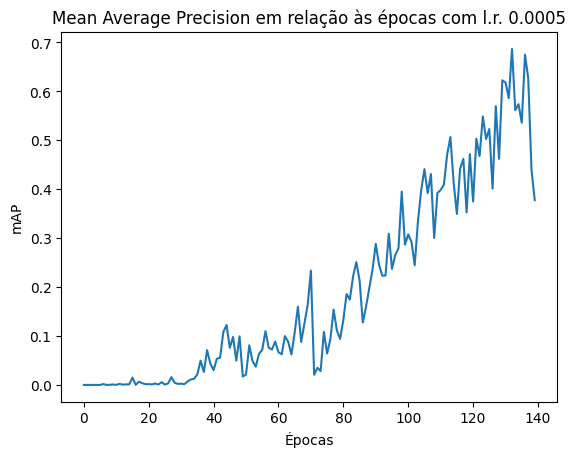

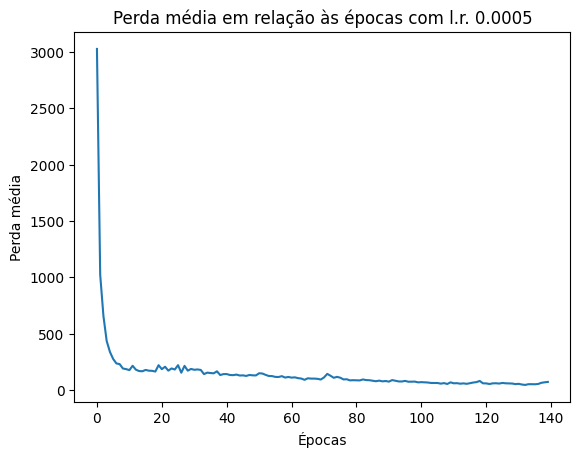

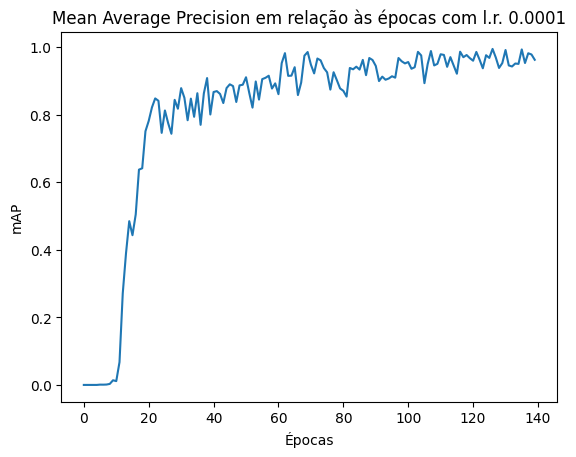

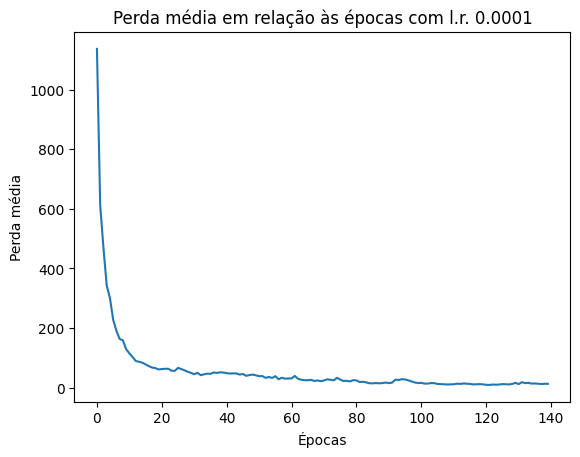

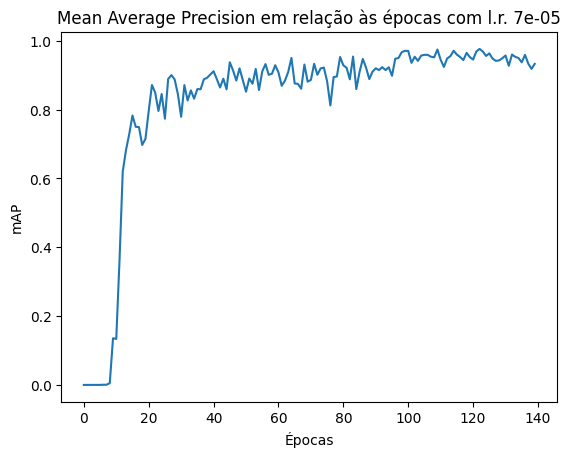

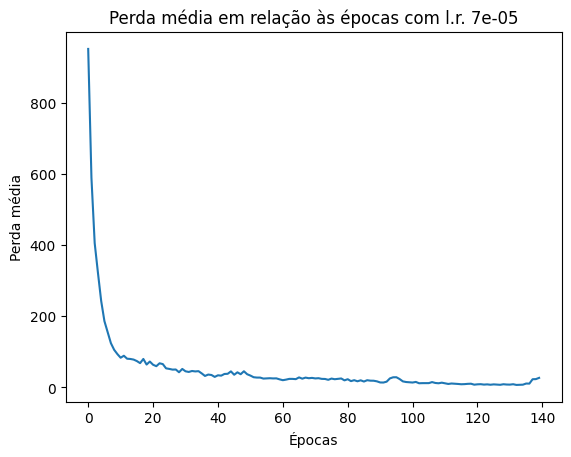


Maximum mAP = 0.9940862655639648 with learning rate = 0.0005

Last maximum mAP = 0.976232647895813 with learning rate = 0.0005

Minimum mean loss = 6.9508092403411865 with learning rate = 0.0005

Last minimum mean loss = 6.9508092403411865 with learning rate = 0.0005


In [ ]:
# Salvamento dos registros de mAP, perda média e tempo
with open(general_path + 'mAPs.txt', 'w') as f:
    for row in mean_avg_precs:
        f.write(f"{row}\n")
f.close()

with open(general_path + 'mean_losses.txt', 'w') as f:
    for row in mean_losses:
        f.write(f"{row}\n")
f.close()

with open(general_path + 'dt.txt', 'w') as f:
    for row in dt:
        f.write(f"{row}\n")
f.close()

lr_to_idx = {5e-4 : 0, 1e-4 : 1, 7e-5 : 2}
for LEARNING_RATE in LEARNING_RATES:
    plt.title(f"Mean Average Precision em relação às épocas com l.r. {LEARNING_RATE}")
    plt.xlabel("Épocas")
    plt.ylabel("mAP")
    plt.plot(range(EPOCHS), mean_avg_precs[lr_to_idx[LEARNING_RATE]])
    plt.show()

    plt.title(f"Perda média em relação às épocas com l.r. {LEARNING_RATE}")
    plt.xlabel("Épocas")
    plt.ylabel("Perda média")
    plt.plot(range(EPOCHS), mean_losses[lr_to_idx[LEARNING_RATE]])
    plt.show()

max_mAP = np.max(mean_avg_precs)
max_mAP_idx = np.argmax(mean_avg_precs, axis=1)
max_mAP_lr = LEARNING_RATES[np.argmax(mean_avg_precs[:][max_mAP_idx] for i in range(3))]
print(f"\nMaximum mAP = {max_mAP} with learning rate = {max_mAP_lr}")

last_max_mAP = np.max(mean_avg_precs[:][-1])
last_max_mAP_idx = np.argmax(mean_avg_precs[i][-1] for i in range(3))
last_max_mAP_lr = LEARNING_RATES[last_max_mAP_idx]
print(f"\nLast maximum mAP = {last_max_mAP} with learning rate = {last_max_mAP_lr}")

min_loss = np.min(mean_losses)
min_loss_idx = np.argmin(mean_losses, axis=1)
min_loss_lr = LEARNING_RATES[np.argmin(mean_losses[i][min_loss_idx] for i in range(3))]
print(f"\nMinimum mean loss = {min_loss} with learning rate = {min_loss_lr}")

last_min_loss = np.min(mean_losses[:][-1])
last_min_loss_idx = np.argmin(mean_losses[i][-1] for i in range(3))
last_min_loss_lr = LEARNING_RATES[last_min_loss_idx]
print(f"\nLast minimum mean loss = {last_min_loss} with learning rate = {last_min_loss_lr}")

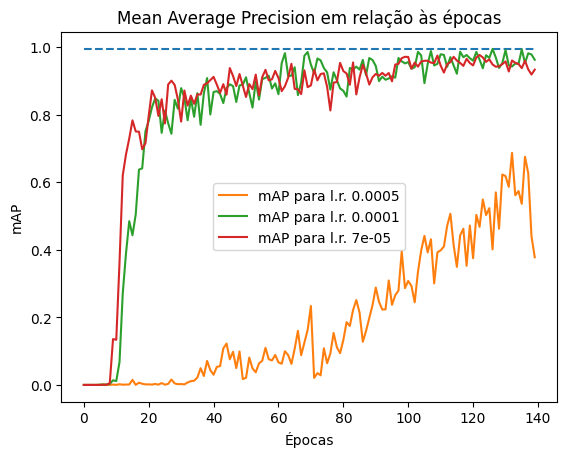

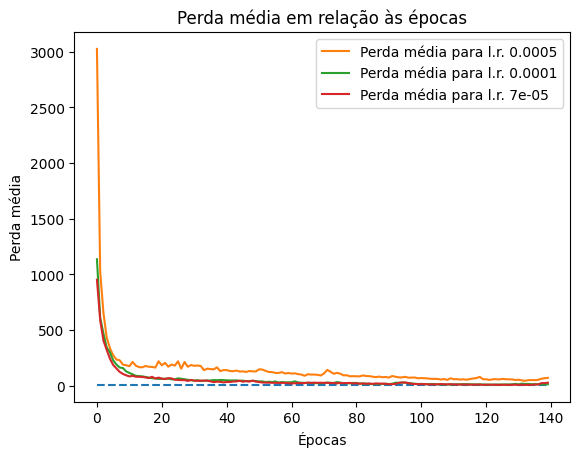



Statistics for epochs >= 99

Mean general mAP = 0.7899332642555237

Mean general mean loss = 27.543164153086142


Std. dev. for general mAP = 0.2438862919807434

Std. dev. for general mean loss = 22.67470172549163


Mean mAP = 0.4573233425617218 with l.r. = 0.0005

Average mean loss = 58.84199920902408 with l.r. = 0.0005

Std. dev. for mAP = 0.10875677317380905 with l.r. = 0.0005

Std. dev. for mean loss = 6.998762588171136 with l.r. = 0.0005


Mean mAP = 0.9604921936988831 with l.r. = 0.0001

Average mean loss = 12.65520015770827 with l.r. = 0.0001

Std. dev. for mAP = 0.021186774596571922 with l.r. = 0.0001

Std. dev. for mean loss = 2.01826042199176 with l.r. = 0.0001


Mean mAP = 0.9519842267036438 with l.r. = 7e-05

Average mean loss = 11.132293092526073 with l.r. = 7e-05

Std. dev. for mAP = 0.01358081866055727 with l.r. = 7e-05

Std. dev. for mean loss = 4.334167206127597 with l.r. = 7e-05


In [ ]:
plt.figure(1)
plt.plot(range(EPOCHS), np.linspace(max_mAP, max_mAP, EPOCHS), '--')

plt.figure(2)
plt.plot(range(EPOCHS), np.linspace(min_loss, min_loss, EPOCHS), '--')

for LEARNING_RATE in LEARNING_RATES:
    plt.figure(1)
    plt.title("Mean Average Precision em relação às épocas")
    plt.xlabel("Épocas")
    plt.ylabel("mAP")
    plt.plot(range(EPOCHS), mean_avg_precs[lr_to_idx[LEARNING_RATE]], label=f"mAP para l.r. {LEARNING_RATE}")
    plt.legend()

    plt.figure(2)
    plt.title("Perda média em relação às épocas")
    plt.xlabel("Épocas")
    plt.ylabel("Perda média")
    plt.plot(range(EPOCHS), mean_losses[lr_to_idx[LEARNING_RATE]], label=f"Perda média para l.r. {LEARNING_RATE}")
    plt.legend()


plt.show()
plt.show()

mean_avg_precs = np.array(mean_avg_precs)
mean_losses = np.array(mean_losses)
print(f"\n\nStatistics for epochs >= 99")
print(f"\nMean general mAP = {np.mean(mean_avg_precs[..., 99:])}")
print(f"\nMean general mean loss = {np.mean(mean_losses[..., 99:])}")

print(f"\n\nStd. dev. for general mAP = {np.std(mean_avg_precs[..., 99:])}")
print(f"\nStd. dev. for general mean loss = {np.std(mean_losses[..., 99:])}")

for LEARNING_RATE in LEARNING_RATES:
    mAP_mean = np.mean(mean_avg_precs[lr_to_idx[LEARNING_RATE]][99:])
    loss_mean = np.mean(mean_losses[lr_to_idx[LEARNING_RATE]][99:])
    mAP_stddev = np.std(mean_avg_precs[lr_to_idx[LEARNING_RATE]][99:])
    loss_stddev = np.std(mean_losses[lr_to_idx[LEARNING_RATE]][99:])

    print(f"\n\nMean mAP = {mAP_mean} with l.r. = {LEARNING_RATE}")
    print(f"\nAverage mean loss = {loss_mean} with l.r. = {LEARNING_RATE}")
    print(f"\nStd. dev. for mAP = {mAP_stddev} with l.r. = {LEARNING_RATE}")
    print(f"\nStd. dev. for mean loss = {loss_stddev} with l.r. = {LEARNING_RATE}")

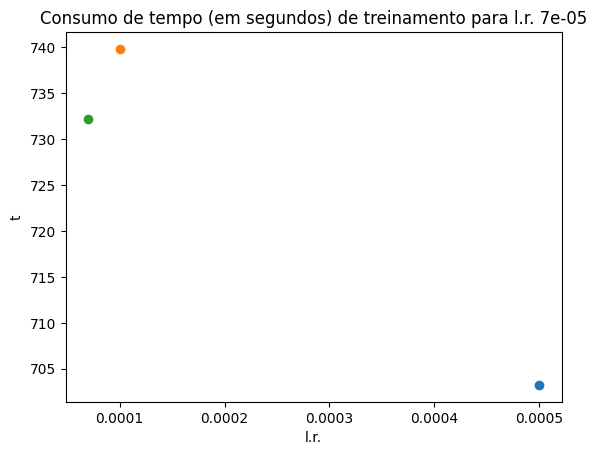


Maximum time = 739.8256316184998 with learning rate = 0.0001

Minimum time = 703.2341907024384 with learning rate = 0.0005


In [ ]:
for LEARNING_RATE in LEARNING_RATES:
    plt.title(f"Consumo de tempo (em segundos) de treinamento para l.r. {LEARNING_RATE}")
    plt.xlabel("l.r.")
    plt.ylabel("t")
    plt.scatter(LEARNING_RATE, dt[lr_to_idx[LEARNING_RATE]])
plt.show()

max_dt = np.max(dt)
max_dt_lr = LEARNING_RATES[np.argmax(dt)]
print(f"\nMaximum time = {max_dt} with learning rate = {max_dt_lr}")

min_dt = np.min(dt)
min_dt_lr = LEARNING_RATES[np.argmin(dt)]
print(f"\nMinimum time = {min_dt} with learning rate = {min_dt_lr}")

<ipython-input-6-7bd6094da9bb>:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load(LOAD_MODEL_FILE, map_location=torch.device('cpu')), model, optimi

=> Loading checkpoint


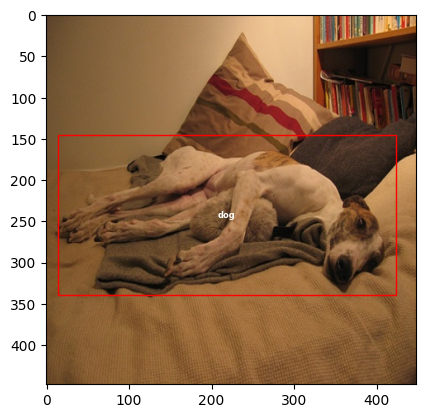

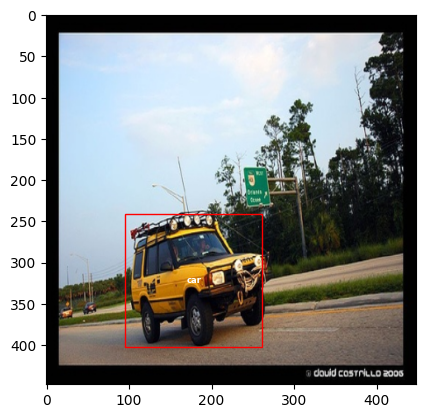

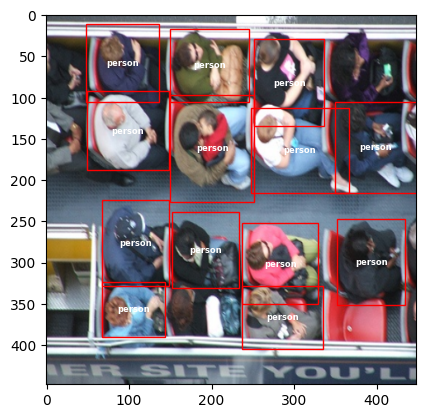

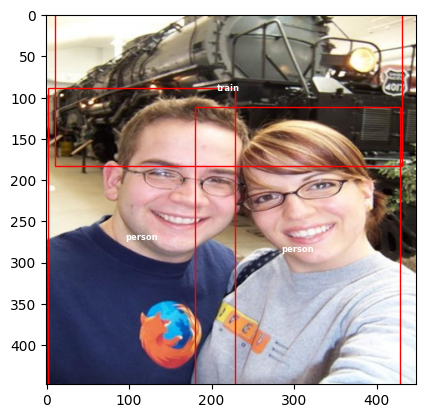

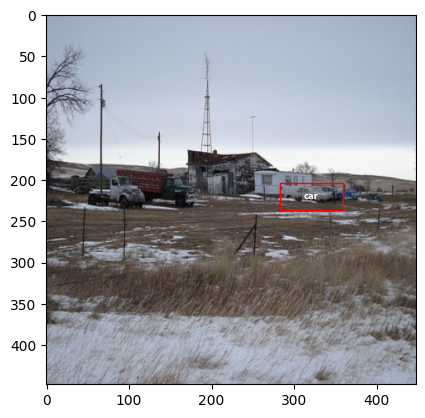

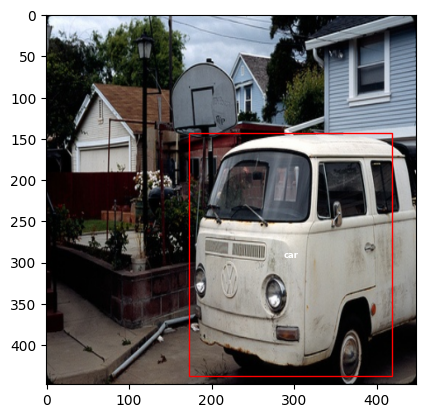

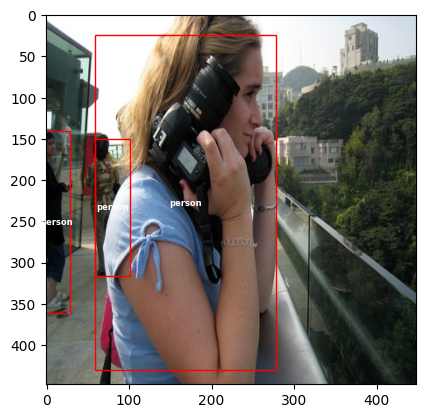

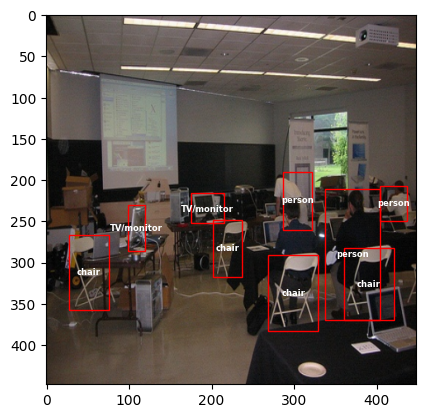

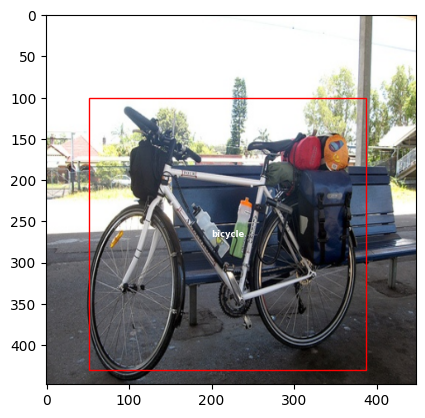

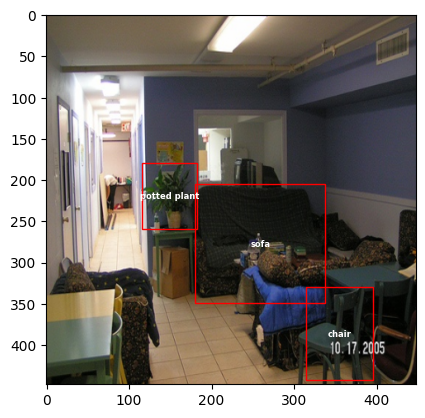

mAP: 0.9999988079071045


100%|██████████| 1/1 [00:15<00:00, 15.34s/it, loss=8.24]


Mean loss was 8.241353988647461


In [ ]:
LEARNING_RATE = 1e-4
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = True
lr_formatting = f"{LEARNING_RATE:.5f}"
lr_formatting = lr_formatting[2:]
LOAD_MODEL_FILE = general_path + f"my_checkpoint{lr_formatting}.pth.tar"
IMG_DIR = general_path + "images"
LABEL_DIR = general_path + "labels"

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

def verification_fn(test_loader, model, loss_fn):
    loop = tqdm(test_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())

        # update progress bar
        loop.set_postfix(loss=loss.item())

    return sum(mean_loss)/len(mean_loss)

def verification_main():
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE, map_location=torch.device('cpu')), model, optimizer)

    verification_dataset = VOCDataset(
        general_path + "100examples.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
        skiprows=90
    )

    verification_loader = DataLoader(
        dataset=verification_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )

    x, y = next(iter(verification_loader))
    x = x.to(DEVICE)
    for idx in range(10):
      bboxes = cellboxes_to_boxes(model(x))
      bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
      plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

    pred_boxes, target_boxes = get_bboxes(
        verification_loader, model, iou_threshold=0.5, threshold=0.4, box_format="midpoint", device=DEVICE
    )

    mean_avg_prec = mean_average_precision(
        pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
    )
    print(f"mAP: {mean_avg_prec}")

    mean_loss = verification_fn(verification_loader, model, loss_fn)
    print(f"Mean loss was {mean_loss}")

verification_main()